In [383]:
import logging

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option("display.max_columns", 200)
import warnings
warnings.filterwarnings('ignore')

import tensorflow.keras as keras

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model

import tensorflow as tf

# Log setting
logging.basicConfig(format="%(asctime)s %(levelname)s %(message)s", datefmt="%H:%M:%S", level=logging.INFO)

## Read datasets and labels

In [384]:
df = pd.read_csv("../data/attack_dataset.csv") # attack dataset
attack_classes = pd.read_csv("../data/attack_labels_sbseg.csv") # labels
bonafide = pd.read_csv('../data/bonafide_dataset_20191121.csv.gz') # bonafide dataset
print(df.shape, bonafide.shape)

(86480, 41) (103094, 41)


### Attack labels

In [385]:
attack_classes['label'].unique()

array(['nmap_tcp_syn', 'nmap_tcp_conn', 'nmap_tcp_null', 'nmap_tcp_xmas',
       'nmap_tcp_fin', 'nmap_tcp_ack', 'nmap_tcp_window',
       'nmap_tcp_maimon', 'unicornscan_tcp_syn', 'unicornscan_tcp_conn',
       'unicornscan_tcp_null', 'unicornscan_tcp_xmas',
       'unicornscan_tcp_fxmas', 'unicornscan_tcp_fin',
       'unicornscan_tcp_ack', 'hping_tcp_syn', 'hping_tcp_null',
       'hping_tcp_xmas', 'hping_tcp_fin', 'hping_tcp_ack', 'zmap_tcp_syn',
       'masscan_tcp_syn'], dtype=object)

### Create **attack dataset** with labels defined by  *ip_src*

In [386]:
df_labeled = df.merge(attack_classes, how='inner', left_on='ip.src', right_on='ip')
df_labeled.drop(['ip'], axis=1, inplace=True)
df_labeled.head(2)

,frame_info.encap_type,frame_info.time,frame_info.time_epoch,frame_info.number,frame_info.len,frame_info.cap_len,eth.type,ip.version,ip.hdr_len,ip.tos,ip.id,ip.flags,ip.flags.rb,ip.flags.df,ip.flags.mf,ip.frag_offset,ip.ttl,ip.proto,ip.checksum,ip.src,ip.dst,ip.len,ip.dsfield,tcp.srcport,tcp.dstport,tcp.seq,tcp.ack,tcp.len,tcp.hdr_len,tcp.flags,tcp.flags.fin,tcp.flags.syn,tcp.flags.reset,tcp.flags.push,tcp.flags.ack,tcp.flags.urg,tcp.flags.cwr,tcp.window_size,tcp.checksum,tcp.urgent_pointer,tcp.options.mss_val,label
0,1,"Dec 31, 1969 21:03:41.953641000 -03",221.953641,20,58,58,0x00000800,4,20,NaN,0x0000b2c5,0x00000000,0,0,0,0,46,6,0x000019e0,172.16.0.3,10.10.10.10,44,0x00000000,62218,8888,0,0,0,24,0x00000002,0,1,0,0,0,0,0,1024,0x00005cb1,0,1460.0,nmap_tcp_syn
1,1,"Dec 31, 1969 21:03:41.953762000 -03",221.953762,21,58,58,0x00000800,4,20,NaN,0x0000d3a4,0x00000000,0,0,0,0,37,6,0x00000201,172.16.0.3,10.10.10.10,44,0x00000000,62218,587,0,0,0,24,0x00000002,0,1,0,0,0,0,0,1024,0x00007d1e,0,1460.0,nmap_tcp_syn


In [387]:
bonafide['label'] = "bonafide" # create column label on bonafide dataset

## Comparing _bonafide_ and _attack_ datasets
> Check if both dataset have the same columns/features/attributes and calculate the balance (%) of bonafide and attack packets

In [388]:
if (df_labeled.columns == bonafide.columns).all():
    examples_attack = df_labeled.shape[0]
    examples_bonafide = bonafide.shape[0]
    total = examples_attack+examples_bonafide
    print('Total examples of {0} with {1:0.2f} of attack and {2:0.2f} bonafide packets'.format(total, examples_attack/total, examples_bonafide/total))

Total examples of 125467 with 0.18 of attack and 0.82 bonafide packets


## Pre-processing
> Required to convert features that were extracted from `pcap` as hexadecimal
> Filled the values with NaN with Zero

In [389]:
fields = ['eth.type', 'ip.id', 'ip.flags', 'ip.checksum', 'ip.dsfield', 'tcp.flags', 'tcp.checksum']

for field in fields:
    df_labeled[field] = df_labeled[field].apply(lambda x: int(str(x), 16))
    

In [390]:
bonafide = bonafide.fillna(0)
for field in fields:
    bonafide[field] = bonafide[field].apply(lambda x: int(str(x), 16))

### Create AB-TRAP dataset with all packets (bonafide and attack)

In [391]:
full_data = pd.concat([bonafide, df_labeled])

### Check if there are packets with the protocol field different than TCP (value 6)

In [392]:
wrong_proto = full_data[full_data['ip.proto'] != 6]['label'].value_counts().values
full_data = full_data[full_data['ip.proto'] == 6]
print("It was found and removed", wrong_proto,"packets.")

It was found and removed [11708] packets.


### Features not applicable to this study

> Remove features from link layer - layer 2:
> - frame_info.time
> - frame_info.encap_type
> - frame_info.time_epoch
> - frame_info.number
> - frame_info.len
> - frame_info.cap_len
> - eth.type

> Remove features that are redundant or invariable
> - ip.version - we consider only IPv4
> - ip.proto - this study is applicable only to TCP
> - ip.src - this attribute is removed to allow the generalization of learning (not learn past attackers)
> - ip.dst - this attribute is removed to allow the generalization of learning (not learn past targets)
> - ip.flags - this is removed because we use bit-set of flags
> - tcp.flags - this is removed because we use bit-set of flags

In [393]:
full_data.drop(columns=['frame_info.time', 'frame_info.encap_type', 'frame_info.time_epoch', 'frame_info.number', 
                        'frame_info.len', 'frame_info.cap_len', 'eth.type', 'ip.flags', 'ip.src', 'ip.dst',
                        'ip.version', 'ip.proto', 'tcp.flags'], axis=1, inplace=True)

## Exploratory Data Analysis

In [394]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113759 entries, 1 to 22372
Data columns (total 29 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ip.hdr_len           113759 non-null  float64
 1   ip.tos               91386 non-null   float64
 2   ip.id                113759 non-null  int64  
 3   ip.flags.rb          113759 non-null  float64
 4   ip.flags.df          113759 non-null  float64
 5   ip.flags.mf          113759 non-null  float64
 6   ip.frag_offset       113759 non-null  float64
 7   ip.ttl               113759 non-null  float64
 8   ip.checksum          113759 non-null  int64  
 9   ip.len               113759 non-null  float64
 10  ip.dsfield           113759 non-null  int64  
 11  tcp.srcport          113759 non-null  float64
 12  tcp.dstport          113759 non-null  float64
 13  tcp.seq              113759 non-null  float64
 14  tcp.ack              113759 non-null  float64
 15  tcp.len              11

In [395]:
full_data.describe()

,ip.hdr_len,ip.tos,ip.id,ip.flags.rb,ip.flags.df,ip.flags.mf,ip.frag_offset,ip.ttl,ip.checksum,ip.len,ip.dsfield,tcp.srcport,tcp.dstport,tcp.seq,tcp.ack,tcp.len,tcp.hdr_len,tcp.flags.fin,tcp.flags.syn,tcp.flags.reset,tcp.flags.push,tcp.flags.ack,tcp.flags.urg,tcp.flags.cwr,tcp.window_size,tcp.checksum,tcp.urgent_pointer,tcp.options.mss_val
count,113759.0,91386.0,113759.000000,113759.0,113759.000000,113759.0,113759.0,113759.000000,113759.000000,113759.000000,113759.000000,113759.000000,113759.000000,1.137590e+05,1.137590e+05,113759.000000,113759.000000,113759.000000,113759.000000,113759.000000,113759.000000,113759.000000,113759.000000,113759.000000,1.137590e+05,113759.000000,113759.000000,100484.000000
mean,20.0,0.0,31347.585993,0.0,0.618316,0.0,0.0,125.907691,32187.994005,629.721332,2.249668,25553.705491,28784.728971,4.012405e+07,4.092436e+07,582.295388,27.425944,0.077137,0.308705,0.022407,0.094683,0.619046,0.035417,0.009608,8.807325e+03,32342.675208,0.766427,198.943693
std,0.0,0.0,19694.286820,0.0,0.485802,0.0,0.0,87.436633,19038.950443,690.759214,8.171465,25107.425855,24827.699185,1.113061e+08,2.439186e+08,688.715939,7.659989,0.266809,0.461961,0.148004,0.292777,0.485624,0.184832,0.097549,7.951332e+04,19024.617715,182.598351,512.382545
min,20.0,0.0,0.000000,0.0,0.000000,0.0,0.0,1.000000,1.000000,40.000000,0.000000,21.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,20.0,0.0,13956.000000,0.0,0.000000,0.0,0.0,59.000000,15260.500000,40.000000,0.000000,443.000000,993.000000,0.000000e+00,0.000000e+00,0.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.290000e+02,15978.000000,0.000000,0.000000
50%,20.0,0.0,31071.000000,0.0,1.000000,0.0,0.0,62.000000,31861.000000,64.000000,0.000000,20166.000000,35008.000000,1.000000e+00,1.000000e+00,0.000000,32.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,6.070000e+02,32081.000000,0.000000,0.000000
75%,20.0,0.0,48841.500000,0.0,1.000000,0.0,0.0,242.000000,48728.500000,1426.000000,0.000000,51351.000000,51436.000000,1.367624e+07,4.610000e+03,1374.000000,32.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.200000e+03,48581.500000,0.000000,0.000000
max,20.0,0.0,65535.000000,0.0,1.000000,0.0,0.0,254.000000,65534.000000,5981.000000,224.000000,65534.000000,65535.000000,4.294967e+09,4.294967e+09,5941.000000,60.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.644544e+07,65533.000000,46335.000000,8961.000000


In [396]:
full_data['label']

1               bonafide
3               bonafide
4               bonafide
5               bonafide
6               bonafide
              ...       
22368    masscan_tcp_syn
22369    masscan_tcp_syn
22370    masscan_tcp_syn
22371    masscan_tcp_syn
22372    masscan_tcp_syn
Name: label, Length: 113759, dtype: object

In [397]:
full_data['label'].unique()

array(['bonafide', 'nmap_tcp_syn', 'nmap_tcp_conn', 'nmap_tcp_null',
       'nmap_tcp_xmas', 'nmap_tcp_fin', 'nmap_tcp_ack', 'nmap_tcp_window',
       'nmap_tcp_maimon', 'unicornscan_tcp_syn', 'unicornscan_tcp_conn',
       'unicornscan_tcp_null', 'unicornscan_tcp_xmas',
       'unicornscan_tcp_fxmas', 'unicornscan_tcp_fin',
       'unicornscan_tcp_ack', 'hping_tcp_syn', 'hping_tcp_null',
       'hping_tcp_xmas', 'hping_tcp_fin', 'hping_tcp_ack', 'zmap_tcp_syn',
       'masscan_tcp_syn'], dtype=object)

In [398]:
# remove columns with zero variance
full_data.drop(columns=['ip.hdr_len', 'ip.tos', 'ip.flags.rb', 
                        'ip.flags.mf', 'ip.frag_offset'], axis=1, inplace=True)

In [399]:
full_data.columns

Index(['ip.id', 'ip.flags.df', 'ip.ttl', 'ip.checksum', 'ip.len', 'ip.dsfield',
       'tcp.srcport', 'tcp.dstport', 'tcp.seq', 'tcp.ack', 'tcp.len',
       'tcp.hdr_len', 'tcp.flags.fin', 'tcp.flags.syn', 'tcp.flags.reset',
       'tcp.flags.push', 'tcp.flags.ack', 'tcp.flags.urg', 'tcp.flags.cwr',
       'tcp.window_size', 'tcp.checksum', 'tcp.urgent_pointer',
       'tcp.options.mss_val', 'label'],
      dtype='object')

### Bivariate Analysis - Linear correlation (absolute threshold of 0.5)

## Binary Classification _(attack x bonafide)_

In [400]:
full_data = full_data.fillna(0)

In [401]:
full_data.shape

(113759, 24)

In [402]:
# It is removed ttl because previous attempt shows that it is learning the LAN architecture TTL=62
# (from scan tools TTL=64 minus 2 routers in the infrastructure)

# sequence, checksum and acknowledge features because they are random

# removed source and destination ports to be agnostic regarding the service ports

# removed tcp.options.mss_val because it is dificult to be retrieved as LKM

full_data.drop(columns=["ip.checksum", "ip.ttl", "tcp.checksum", "tcp.dstport", "tcp.seq", "tcp.srcport", 
                        "tcp.ack", "tcp.options.mss_val"], axis=1, inplace=True)

In [403]:
full_data

,ip.id,ip.flags.df,ip.len,ip.dsfield,tcp.len,tcp.hdr_len,tcp.flags.fin,tcp.flags.syn,tcp.flags.reset,tcp.flags.push,tcp.flags.ack,tcp.flags.urg,tcp.flags.cwr,tcp.window_size,tcp.urgent_pointer,label
1,46834,0.0,40.0,0,0.0,20.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1024.0,0.0,bonafide
3,3793,1.0,537.0,8,485.0,32.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,252.0,0.0,bonafide
4,0,1.0,80.0,0,0.0,60.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4677.0,0.0,bonafide
5,8559,1.0,54.0,0,2.0,32.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,115.0,0.0,bonafide
6,54321,0.0,40.0,8,0.0,20.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,65535.0,0.0,bonafide
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22368,32904,0.0,40.0,0,0.0,20.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1024.0,0.0,masscan_tcp_syn
22369,55978,0.0,40.0,0,0.0,20.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1200.0,0.0,masscan_tcp_syn
22370,32903,0.0,40.0,0,0.0,20.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1200.0,0.0,masscan_tcp_syn
22371,6985,0.0,40.0,0,0.0,20.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1024.0,0.0,masscan_tcp_syn


In [404]:
full_data.fillna(0)

,ip.id,ip.flags.df,ip.len,ip.dsfield,tcp.len,tcp.hdr_len,tcp.flags.fin,tcp.flags.syn,tcp.flags.reset,tcp.flags.push,tcp.flags.ack,tcp.flags.urg,tcp.flags.cwr,tcp.window_size,tcp.urgent_pointer,label
1,46834,0.0,40.0,0,0.0,20.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1024.0,0.0,bonafide
3,3793,1.0,537.0,8,485.0,32.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,252.0,0.0,bonafide
4,0,1.0,80.0,0,0.0,60.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4677.0,0.0,bonafide
5,8559,1.0,54.0,0,2.0,32.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,115.0,0.0,bonafide
6,54321,0.0,40.0,8,0.0,20.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,65535.0,0.0,bonafide
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22368,32904,0.0,40.0,0,0.0,20.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1024.0,0.0,masscan_tcp_syn
22369,55978,0.0,40.0,0,0.0,20.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1200.0,0.0,masscan_tcp_syn
22370,32903,0.0,40.0,0,0.0,20.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1200.0,0.0,masscan_tcp_syn
22371,6985,0.0,40.0,0,0.0,20.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1024.0,0.0,masscan_tcp_syn


In [405]:
class_names = full_data['label'].unique()
class_names

array(['bonafide', 'nmap_tcp_syn', 'nmap_tcp_conn', 'nmap_tcp_null',
       'nmap_tcp_xmas', 'nmap_tcp_fin', 'nmap_tcp_ack', 'nmap_tcp_window',
       'nmap_tcp_maimon', 'unicornscan_tcp_syn', 'unicornscan_tcp_conn',
       'unicornscan_tcp_null', 'unicornscan_tcp_xmas',
       'unicornscan_tcp_fxmas', 'unicornscan_tcp_fin',
       'unicornscan_tcp_ack', 'hping_tcp_syn', 'hping_tcp_null',
       'hping_tcp_xmas', 'hping_tcp_fin', 'hping_tcp_ack', 'zmap_tcp_syn',
       'masscan_tcp_syn'], dtype=object)

In [406]:
class_dict = {}

class_dict['bonafide'] = 0

class_dict['nmap_tcp_syn'] = 1
class_dict['unicornscan_tcp_syn'] = 1
class_dict['masscan_tcp_syn'] = 1
class_dict['zmap_tcp_syn'] = 1
class_dict['hping_tcp_syn'] = 1


class_dict['nmap_tcp_null'] = 2
class_dict['hping_tcp_null'] = 2
class_dict['unicornscan_tcp_null'] = 2

class_dict['nmap_tcp_ack'] = 3
class_dict['unicornscan_tcp_ack'] = 3
class_dict['hping_tcp_ack'] = 3

class_dict['nmap_tcp_fin'] = 4
class_dict['unicornscan_tcp_fin'] = 4
class_dict['hping_tcp_fin'] = 4

# for i, class_name in enumerate(class_names):
#     class_dict[class_name] = i

In [407]:
full_data['label']= full_data['label'].map(class_dict)

In [408]:
full_data = full_data.dropna()

In [409]:
full_data['label'].unique()

array([0., 1., 2., 4., 3.])

In [410]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 105702 entries, 1 to 22372
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ip.id               105702 non-null  int64  
 1   ip.flags.df         105702 non-null  float64
 2   ip.len              105702 non-null  float64
 3   ip.dsfield          105702 non-null  int64  
 4   tcp.len             105702 non-null  float64
 5   tcp.hdr_len         105702 non-null  float64
 6   tcp.flags.fin       105702 non-null  float64
 7   tcp.flags.syn       105702 non-null  float64
 8   tcp.flags.reset     105702 non-null  float64
 9   tcp.flags.push      105702 non-null  float64
 10  tcp.flags.ack       105702 non-null  float64
 11  tcp.flags.urg       105702 non-null  float64
 12  tcp.flags.cwr       105702 non-null  float64
 13  tcp.window_size     105702 non-null  float64
 14  tcp.urgent_pointer  105702 non-null  float64
 15  label               105702 non-null  flo

In [413]:
y = full_data['label']

In [412]:
X = full_data.drop(columns=['label'])

In [414]:

print(X.shape, y.shape)

(105702, 15) (105702,)


In [415]:
X.head()

,ip.id,ip.flags.df,ip.len,ip.dsfield,tcp.len,tcp.hdr_len,tcp.flags.fin,tcp.flags.syn,tcp.flags.reset,tcp.flags.push,tcp.flags.ack,tcp.flags.urg,tcp.flags.cwr,tcp.window_size,tcp.urgent_pointer
1,46834,0.0,40.0,0,0.0,20.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1024.0,0.0
3,3793,1.0,537.0,8,485.0,32.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,252.0,0.0
4,0,1.0,80.0,0,0.0,60.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4677.0,0.0
5,8559,1.0,54.0,0,2.0,32.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,115.0,0.0
6,54321,0.0,40.0,8,0.0,20.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,65535.0,0.0


In [416]:
X = X.astype(int) 
X.head()

,ip.id,ip.flags.df,ip.len,ip.dsfield,tcp.len,tcp.hdr_len,tcp.flags.fin,tcp.flags.syn,tcp.flags.reset,tcp.flags.push,tcp.flags.ack,tcp.flags.urg,tcp.flags.cwr,tcp.window_size,tcp.urgent_pointer
1,46834,0,40,0,0,20,0,1,0,0,0,0,0,1024,0
3,3793,1,537,8,485,32,0,0,0,1,1,0,0,252,0
4,0,1,80,0,0,60,0,0,0,0,1,0,0,4677,0
5,8559,1,54,0,2,32,0,0,0,1,1,0,0,115,0
6,54321,0,40,8,0,20,0,1,0,0,0,0,0,65535,0


## CNN model

In [359]:
def create_cnn_model() -> keras.Model:
    # Creating layers
    inputs = keras.layers.Input(shape=(4, 4, 1))
    x = keras.layers.Conv2D(110, 2, activation='relu', padding="same")(inputs)
    x = keras.layers.MaxPooling2D(2)(x)
    x = keras.layers.Conv2D(55, 3, activation='relu', padding="same")(x)
    x = keras.layers.MaxPooling2D(2)(x)
    x = keras.layers.Conv2D(26, 4, activation='relu', padding="same")(x)
    x = keras.layers.Reshape((1, 26))(x)
    x = keras.layers.GRU(55, return_sequences=True)(x)
    x = keras.layers.GRU(26)(x)
    x = keras.layers.Flatten()(x)
    outputs = keras.layers.Dense(5, activation='softmax')(x)
    cnn_model = keras.Model(inputs=inputs, outputs=outputs, name='cnn')

    # Compile layers
    cnn_model.compile(loss='sparse_categorical_crossentropy',
                      metrics=['sparse_categorical_accuracy'],
                      optimizer='adam')

    return cnn_model

In [360]:
# Create model
model = create_cnn_model()
logging.info(model.summary())

Model: "cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 4, 4, 1)]         0         
                                                                 
 conv2d_81 (Conv2D)          (None, 4, 4, 110)         550       
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 2, 2, 110)        0         
 g2D)                                                            
                                                                 
 conv2d_82 (Conv2D)          (None, 2, 2, 55)          54505     
                                                                 
 max_pooling2d_55 (MaxPoolin  (None, 1, 1, 55)         0         
 g2D)                                                            
                                                                 
 conv2d_83 (Conv2D)          (None, 1, 1, 26)          22906   

2023-06-11 20:43:01.924996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-11 20:43:01.925768: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-11 20:43:01.926160: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [351]:
def reshape_dataset_cnn(x: np.ndarray) -> np.ndarray:
    # Add padding columns
    result = np.zeros((x.shape[0], 16))
    result[:, :-1] = x

    # Reshaping dataset
    result = np.reshape(result, (result.shape[0], 4, 4))
    result = result[..., tf.newaxis]
    return result

In [352]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)

In [353]:
X_train = reshape_dataset_cnn(X_train)

In [354]:
X_train.shape

(76218, 4, 4, 1)

In [357]:
y_train.head()

9338     0
19799    0
14720    0
62369    0
18662    1
Name: label, dtype: int64

In [370]:
# Training
logging.info("*** TRAINING START ***")
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=1024, verbose=3)

20:45:19 INFO *** TRAINING START ***


Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


In [376]:
model.save("../saved_model_ab_trap.h5")

In [377]:
def plot_history(history: tf.keras.callbacks.History):
    # summarize history for accuracy
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.title('model sparse categorical accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training accuracy', 'validation accuracy'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model sparse binary_crossentropy loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training loss', 'validation loss'], loc='upper right')
    plt.show()

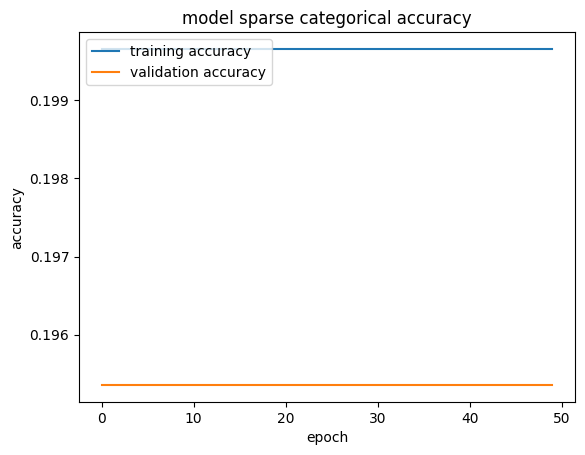

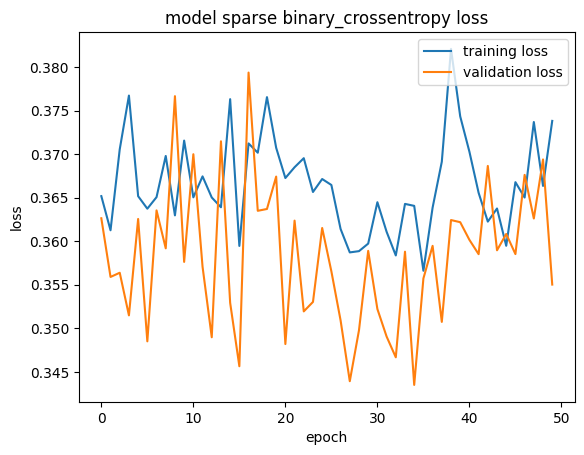

In [378]:
plot_history(history)

In [379]:
from sklearn.metrics import classification_report

In [380]:
X_test = reshape_dataset_cnn(X_test)

ValueError: could not broadcast input array from shape (37541,4,4,1) into shape (37541,15)

In [381]:
score = model.evaluate(X_test, y_test, verbose=False)
logging.info('Evaluation:\nLoss: {}\nAccuracy : {}\n'.format(score[0], score[1]))

20:46:06 INFO Evaluation:
Loss: 0.35604846477508545
Accuracy : 0.19234970211982727



In [382]:
   
y_pred = model.predict(X_test, batch_size=1024, verbose=False)
y_pred = np.argmax(y_pred, axis=1)

logging.info("\n{}".format(classification_report(y_test, y_pred)))

20:46:09 INFO 
              precision    recall  f1-score   support

           0       0.81      1.00      0.89     30320
           1       0.00      0.00      0.00      7221

    accuracy                           0.81     37541
   macro avg       0.40      0.50      0.45     37541
weighted avg       0.65      0.81      0.72     37541

